In [1]:
import pandas as pd #for handling dataframes
import numpy as np #for handling arrays
import matplotlib . pyplot as plt #to make the graphd
from sklearn.cluster import KMeans
from sklearn . preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [3]:
batting_df = pd.read_csv("bating.csv")
bowling_df = pd.read_csv("bowling.csv")

In [4]:
batting_df = batting_df.rename(columns={'Mat': 'Matches'})
bowling_df = bowling_df.rename(columns={'Mat': 'Matches'})

In [5]:
batting_df.head()

,Player,Span,Matches,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,4s,6s
0,Shubman Gill,2020-2024,45,45,7,2312,208,60.84,2256,102.48,6,13,1,257,52
1,V Kohli,2020-2024,53,50,5,2297,166*,51.04,2421,94.87,7,17,3,207,32
2,KL Rahul,2020-2024,51,47,10,1962,112,53.02,2158,90.91,4,13,1,152,47
3,SS Iyer,2020-2024,50,47,6,1945,128*,47.43,1938,100.36,5,12,1,187,48
4,RG Sharma,2020-2024,44,43,4,1922,131,49.28,1692,113.59,3,14,3,211,93


In [6]:
bowling_df.head()

,Player,Span,Matches,Inns,Overs,Mdns,Runs,Wkts,BBI,Ave,Econ,SR,4,5
0,Kuldeep Yadav,2020-2024,50,49,402.5,18,2017,73,25-May,27.63,5,33.1,3,1
1,Mohammed Siraj,2022-2024,43,42,319.1,32,1631,71,21-Jun,22.97,5.11,26.9,2,1
2,Mohammed Shami,2020-2023,28,28,212.4,12,1218,59,Jul-57,20.64,5.72,21.6,2,4
3,SN Thakur,2020-2023,40,39,269.3,10,1675,57,Apr-37,29.38,6.21,28.3,2,0
4,JJ Bumrah,2020-2023,31,30,261.5,22,1255,46,19-Jun,27.28,4.79,34.1,1,1


**because we need each matrix for each player ( run, wkts ) we need both of data frames of each player combined**

In [7]:
df = pd.merge(batting_df, bowling_df, on='Player' , how='outer' , suffixes=('_bat','_bowl'))
# as runs is a common column for bating and bowling data frame
df.head()

,Player,Span_bat,Matches_bat,Inns_bat,NO,Runs_bat,HS,Ave_bat,BF,SR_bat,...,Overs,Mdns,Runs_bowl,Wkts,BBI,Ave_bowl,Econ,SR_bowl,4,5
0,AR Patel,2022-2024,22,19,4,387,64*,25.8,417,92.8,...,145.3,7,675,19,24-Mar,35.52,4.63,45.9,0,0
1,Arshdeep Singh,2022-2024,8,5,1,37,18,9.25,33,112.12,...,57.1,2,289,12,May-37,24.08,5.05,28.5,1,1
2,Avesh Khan,2022-2023,8,4,1,23,10,7.66,29,79.31,...,59.2,5,329,9,27-Apr,36.55,5.54,39.5,1,0
3,B Kumar,2021-2022,7,3,1,26,19*,13,44,59.09,...,66,0,383,9,Mar-42,42.55,5.8,44,0,0
4,B Sai Sudharsan,2023-2023,3,3,1,127,62,63.5,142,89.43,...,0.3,0,8,0,-,-,16,-,0,0


**Preprocessing**

In [8]:
#as there were empty column
df.fillna(0, inplace=True)

In [9]:
#renaming Runs_bat to Runs as thats the only relivent matrix
df.rename(columns={'Runs_bat':'Runs'}, inplace=True)

In [10]:
# Convert Runs and Wkts to numeric , coercing errors to NaN and then filling with 0
df['Runs'] = pd.to_numeric(df['Runs'], errors='coerce').fillna(0)
df['Wkts'] = pd.to_numeric(df['Wkts'], errors='coerce').fillna(0)


In [11]:
x = df[['Runs', 'Wkts']].values

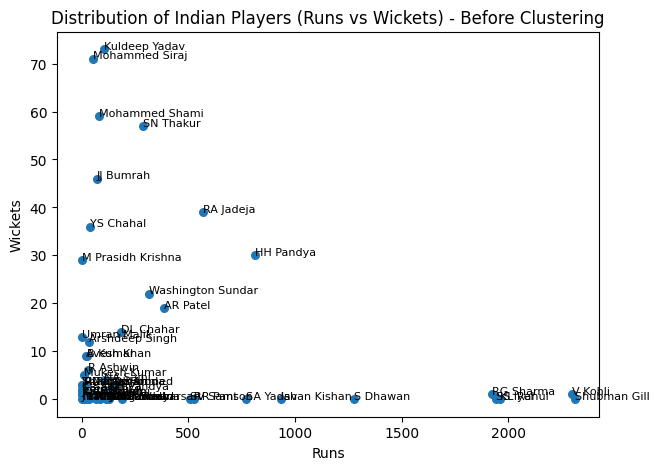

In [12]:
# Scatter plot of runs vs wickets
plt.figure(figsize=(7, 5))
plt.scatter(x[:, 0], x[:, 1], s=30)  # s controls marker size # Changed X to x
plt.xlabel('Runs')
plt.ylabel('Wickets')
plt.title('Distribution of Indian Players (Runs vs Wickets) - Before Clustering')

for i, txt in enumerate(df['Player']):
    plt.annotate(txt, (x[i, 0], x[i, 1]), fontsize=8) # Changed X to x

plt.show()

**removing players which played less than 10 matches as their stats are not soo much relevent as the timeline is only 4 recent years **

In [13]:
min_matches = 10  # set min no. of matches

# Use the correct column names: 'Matches_bat' and 'Matches_bowl'
df = df[(df['Matches_bat'] >= min_matches) | (df['Matches_bowl'] >= min_matches)]

**lets see whether the min no. of matches are removed**

In [14]:
x = df[['Runs', 'Wkts']].values

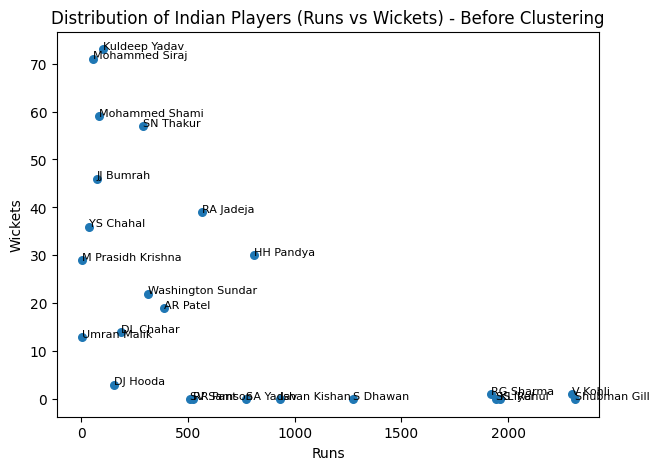

In [15]:
plt.figure(figsize=(7, 5))
plt.scatter(x[:, 0], x[:, 1], s=30)
plt.xlabel('Runs')
plt.ylabel('Wickets')
plt.title('Distribution of Indian Players (Runs vs Wickets) - Before Clustering')

for i, txt in enumerate(df['Player']):
    plt.annotate(txt, (x[i, 0], x[i, 1]), fontsize=8)

plt.show()

In [16]:
initial_k=3
kmeans_initial = KMeans(n_clusters=initial_k, random_state=42, n_init='auto')
kmeans_initial.fit(x)

KMeans(n_clusters=3, random_state=42)

In [17]:
initial_labels = kmeans_initial.labels_
df['Initial_Cluster'] = initial_labels # for each cluster add labels

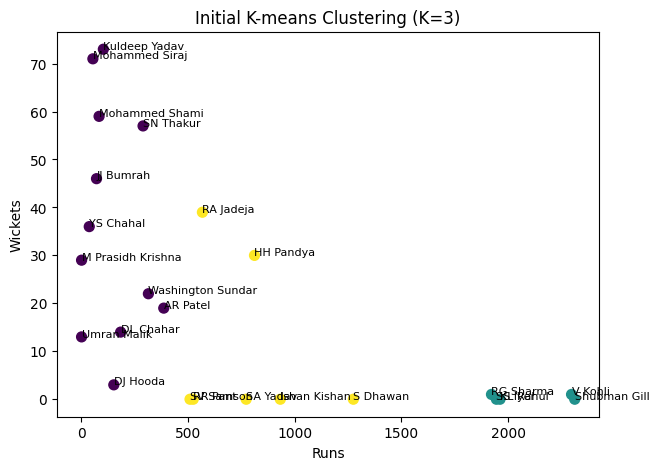

In [19]:
plt.figure(figsize=(7, 5))
plt.scatter(x[:, 0], x[:, 1], c=initial_labels, s=50) # Changed X to x
# plt.scatter(kmeans_initial.cluster_centers_[:, 0], kmeans_initial.cluster_centers_[:, 1], marker='x', s=100, linewidths=3, color='red', label='Cluster Centers')
plt.xlabel('Runs')
plt.ylabel('Wickets')
plt.title(f'Initial K-means Clustering (K={initial_k})')
for i, txt in enumerate(df['Player']):
    plt.annotate(txt, (x[i, 0], x[i, 1]), fontsize=8) # Changed X to x
plt.show()

**green cluster- batsman, yellow cluster- all rounders, violet cluster- bowlers **

*compare bwtween ra jadeja and AR patel*
* we can see that ra jadeja scored 40 wkts over 4 years   
* but ar patel has scores less than 20 wkts
*  but then also ar patel is bawler and jadeja is all rounder
**why this happens**
if you see on x-y axis we have the same unit so
for this code we did not give any scaling here 1 run = 1 wkt
but in real worls both of these tasks are not equlivalent
this is why we are getting wrong clustering here

In [20]:
#solution
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [23]:
k = 3
kmeans_scaling = KMeans(n_clusters=k, init='random', random_state=42, n_init = 'auto')
kmeans_scaling.fit(x_scaled)
scaling_labels = kmeans_scaling.labels_
df['Cluster_Scale'] = scaling_labels

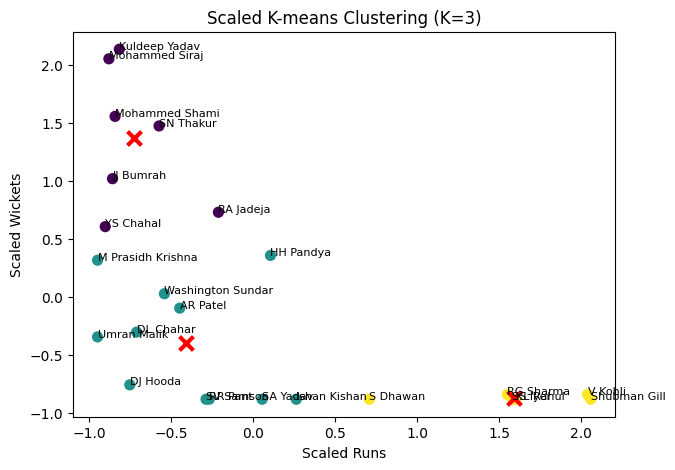

In [25]:
plt.figure(figsize=(7, 5))
plt.scatter(x_scaled[:, 0], x_scaled[:, 1], c=scaling_labels, s=50)
plt.scatter(kmeans_scaling.cluster_centers_[:, 0], kmeans_scaling.cluster_centers_[:, 1], marker='x', s=100, linewidths=3, color='red', label='Cluster Centers')
plt.xlabel('Scaled Runs')
plt.ylabel('Scaled Wickets')
plt.title(f'Scaled K-means Clustering (K={k})')
for i, txt in enumerate(df['Player']):

    plt.annotate(txt, (x_scaled[i, 0], x_scaled[i, 1]), fontsize=8)
plt.show()

In [27]:
sse = []
K = range(1, 11) # K cannot be greater than the number of samples
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 'auto')
    kmeans.fit(x_scaled)
    sse.append(kmeans.inertia_)

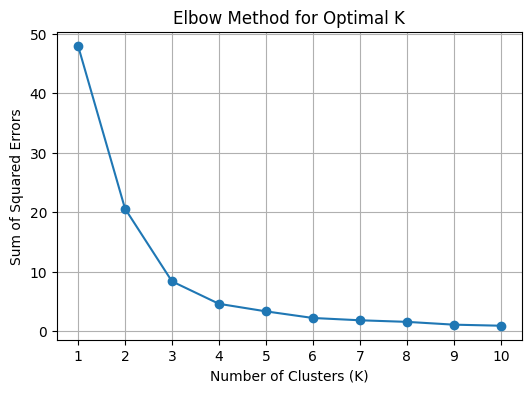

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(K, sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method for Optimal K')
plt.xticks(K) # Set x-axis ticks to integer values
plt.grid(True) # Add grid for better readability